In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
from typing import Tuple
from sklearn.metrics import f1_score


class GCNNodeClassifier(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, num_classes: int):
        super(GCNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.classifier = torch.nn.Linear(output_dim, num_classes)
    
    def forward(self, data: Data) -> torch.Tensor:
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return self.classifier(x)


def loss_fn(preds: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    return F.cross_entropy(preds, labels)


def train(model: GCNNodeClassifier, loader: DataLoader, optimizer: torch.optim.Optimizer) -> float:
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate(model: GCNNodeClassifier, loader: DataLoader) -> float:
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            preds.append(out.argmax(dim=1))
            labels.append(data.y)
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    return f1_score(y_pred=preds.numpy(), y_true=labels.numpy(), average='macro')


def synth_graph(V: int, E: int, C: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    node_features = torch.randn(V, 3)
    edges = torch.randint(0, V, (E, 2))
    node_labels = torch.randint(0, C, (V,))
    for i in range(V):
        if not (edges == i).any():
            edges[torch.randint(0, V, (1,))] = i
    return node_features, edges, node_labels


def split(node_features: torch.Tensor, edges: torch.Tensor, node_labels: torch.Tensor) -> Tuple[DataLoader, DataLoader, DataLoader]:
    E = len(edges)
    edge_index = edges.t().contiguous()
    data = Data(x=node_features, edge_index=edge_index, y=node_labels)
    train_data = Data(x=data.x, edge_index=data.edge_index, y=data.y)
    val_data = Data(x=data.x, edge_index=data.edge_index, y=data.y)
    test_data = Data(x=data.x, edge_index=data.edge_index, y=data.y)
    train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
    val_loader = DataLoader([val_data], batch_size=1, shuffle=False)
    test_loader = DataLoader([test_data], batch_size=1, shuffle=False)
    return train_loader, val_loader, test_loader


# parameters
epochs = 3000
V = 1_000
E = 100_000
C = 3  # Number of classes

# synthesize data, split into train val test
node_features, edges, node_labels = synth_graph(V=V, E=E, C=C)
train_loader, val_loader, test_loader = split(node_features=node_features, edges=edges, node_labels=node_labels)

# train eval
model = GCNNodeClassifier(input_dim=3, hidden_dim=16, output_dim=16, num_classes=C)
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(epochs):
    loss = train(model, train_loader, optimizer)
    if epoch % 300 == 0:
        train_f1 = evaluate(model, train_loader) 
        val_f1 = evaluate(model, val_loader)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, train f1: {train_f1:.4f}, val f1: {val_f1:.4f}')
print(f'Test F1 Score: {evaluate(model, test_loader):.4f}')


Epoch: 0, Loss: 1.1064, train f1: 0.1581, val f1: 0.1581
Epoch: 300, Loss: 1.0826, train f1: 0.3270, val f1: 0.3270
Epoch: 600, Loss: 1.0732, train f1: 0.4000, val f1: 0.4000
Epoch: 900, Loss: 1.0688, train f1: 0.4262, val f1: 0.4262
Epoch: 1200, Loss: 1.0636, train f1: 0.4246, val f1: 0.4246
Epoch: 1500, Loss: 1.0620, train f1: 0.4291, val f1: 0.4291
Epoch: 1800, Loss: 1.0599, train f1: 0.4177, val f1: 0.4177
Epoch: 2100, Loss: 1.0592, train f1: 0.4224, val f1: 0.4224
Epoch: 2400, Loss: 1.0576, train f1: 0.4234, val f1: 0.4234
Epoch: 2700, Loss: 1.0565, train f1: 0.4341, val f1: 0.4341
Test F1 Score: 0.4036


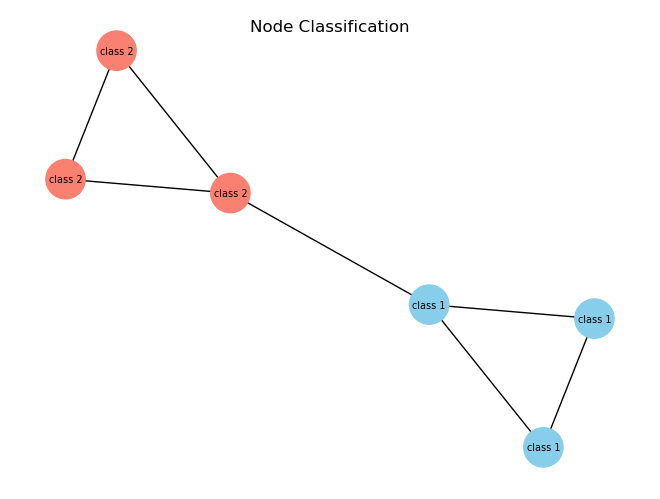

In [17]:
import matplotlib.pyplot as plt
import networkx as nx


G = nx.Graph()

# nodes of two classes
nodes_class_1 = [1, 2, 3]
nodes_class_2 = [4, 5, 6]
for node in nodes_class_1:
    G.add_node(node, label="class 1", color="skyblue")
for node in nodes_class_2:
    G.add_node(node, label="class 2", color="salmon")
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_labels = {node: G.nodes[node]['label'] for node in G.nodes}

# edges
edges = [(1, 2), (1, 3), (1, 6), (2, 3), (4, 5), (4, 6), (5, 6)]
G.add_edges_from(edges)

# plot
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, node_size=800, font_size=7, font_color='black', edge_color='black')
plt.suptitle("Node Classification")
plt.savefig("node_classification.png")
